In [26]:
import torch
import torch.optim as optim
import torch.nn as nn
import sentencepiece as spm
from transformer import Transformer
from dataset2 import load_and_process_data
from torch.utils.data import DataLoader,TensorDataset,random_split
from paddingmask import create_padding_mask, make_pad_kpm, make_causal_mask


In [27]:
# 加载训练好的分词器
sp = spm.SentencePieceProcessor()
sp.load('spm_model.model')  # 替换为你训练的分词器模型路径

# 获取分词器词汇表大小
vocab_size = len(sp)  # 词汇表大小
print(f"Vocabulary size: {vocab_size}")
# 初始化模型参数
vocab_size = len(sp)  # 使用分词器词汇表大小
embed_size = 256
num_heads = 8
num_layers = 6
hidden_dim = 512
# 假设pad_token是填充标记
#pad_token = 617  # 填充标记的ID
pad_id = sp.piece_to_id('<pad>') 

# 创建Transformer模型
model = Transformer(vocab_size, embed_size, num_heads, num_layers, hidden_dim)

# 准备数据
file_path = "train_data.txt"  # 替换为你的数据文件路径
# 调用函数加载和处理数据
chinese_ids_padded, english_ids_padded = load_and_process_data(file_path)
#train_data = torch.tensor(list(zip(chinese_ids, english_ids)))
# 将数据转换为Tensor格式


full_dataset = TensorDataset(
    torch.tensor(chinese_ids_padded, dtype=torch.long),
    torch.tensor(english_ids_padded, dtype=torch.long)
)

val_ratio = 0.05  # 验证集占比
n_val = max(1, int(len(full_dataset) * val_ratio))
n_train = len(full_dataset) - n_val

train_dataset, val_dataset = random_split(
    full_dataset, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)  # 固定划分
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, pin_memory=True)



# train_data = TensorDataset(torch.tensor(chinese_ids_padded), torch.tensor(english_ids_padded))
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# 定义损失函数和优化器
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 把整模型先搬到GPU

Vocabulary size: 32000


Transformer(
  (embedding): TransformerEmbedding(
    (token_embedding): Embedding(32000, 256)
    (positional_encoding): PositionalEncoding()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer_norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamica

In [28]:
%matplotlib inline
from pathlib import Path
import math
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt
from IPython.display import display

# —— 显示设置（先跑一次这个 cell）——
d2l.use_svg_display()
plt.rcParams['figure.dpi'] = 150

In [29]:
def token_accuracy_from_logits(logits, targets, pad_id):
    """logits: (B,L,V), targets: (B,L)"""
    preds = logits.argmax(-1)
    mask = targets.ne(pad_id)  # True=有效token
    correct = (preds.eq(targets) & mask).sum().item()
    total = mask.sum().item()
    return correct, total


def evaluate_on_loader(model, loader, pad_id, device):
    """返回 (val_loss_by_token, val_token_acc)"""
    model.eval()
    ce_sum, tok_sum = 0.0, 0
    correct_sum = 0
    criterion_sum = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction='sum')
    with torch.no_grad():
        for src, tgt in loader:
            src = src.to(device, non_blocking=True)
            tgt = tgt.to(device, non_blocking=True)
            tgt_inp = tgt[:, :-1]
            tgt_out = tgt[:, 1:]

            # key_padding_mask 语义：True=pad（被屏蔽）
            src_kpm = src.eq(pad_id)       # (B,L_src)  bool
            tgt_kpm = tgt_inp.eq(pad_id)   # (B,L_tgt)  bool
            causal  = make_causal_mask(tgt_inp.size(1), device=device)

            logits = model(src, tgt_inp, src_kpm, tgt_kpm, causal)  # (B,L,V)
            loss_sum = criterion_sum(logits.reshape(-1, logits.size(-1)),
                                     tgt_out.reshape(-1))           # 累计总loss
            ce_sum += loss_sum.item()
            valid = (tgt_out != pad_id).sum().item()
            tok_sum += valid

            c, _ = token_accuracy_from_logits(logits, tgt_out, pad_id)
            correct_sum += c
    return ce_sum / max(tok_sum, 1), correct_sum / max(tok_sum, 1)


In [30]:
def train_and_plot(model, train_loader, val_loader, optimizer, pad_id, num_epochs, device):
    # 按 token 计平均（更严谨）
    criterion_sum = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction='sum')

    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss/acc',
        legend=['train loss', 'train acc', 'val acc'],
        xlim=[1, num_epochs], ylim=[0, 1]
    )
    train_loss_hist, train_acc_hist, val_acc_hist = [], [], []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_ce_sum, epoch_tok_sum = 0.0, 0
        epoch_correct = 0

        for src, tgt in train_loader:
            src = src.to(device, non_blocking=True)
            tgt = tgt.to(device, non_blocking=True)

            tgt_inp = tgt[:, :-1]
            tgt_out = tgt[:, 1:]

            src_kpm = src.eq(pad_id)
            tgt_kpm = tgt_inp.eq(pad_id)
            causal  = make_causal_mask(tgt_inp.size(1), device=device)

            logits = model(src, tgt_inp, src_kpm, tgt_kpm, causal)  # (B,L,V)
            # “sum”再除以有效token数，反传更稳定
            loss_sum = criterion_sum(logits.reshape(-1, logits.size(-1)),
                                     tgt_out.reshape(-1))
            valid = (tgt_out != pad_id).sum().item()

            optimizer.zero_grad(set_to_none=True)
            (loss_sum / max(valid, 1)).backward()
            optimizer.step()

            # 统计（按 token 加权）
            epoch_ce_sum += loss_sum.item()
            epoch_tok_sum += valid
            c, _ = token_accuracy_from_logits(logits, tgt_out, pad_id)
            epoch_correct += c

        train_loss = epoch_ce_sum / max(epoch_tok_sum, 1)         # token 平均 loss
        train_acc  = epoch_correct / max(epoch_tok_sum, 1)        # token 准确率
        _,  val_acc = evaluate_on_loader(model, val_loader, pad_id, device)

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        animator.add(epoch + 1, (train_loss, train_acc, val_acc))
        print(f"Epoch {epoch+1:2d} | train_loss={train_loss:.4f} "
              f"(ppl={math.exp(train_loss):.2f}) | train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

    # —— 结束后强制显示并保存（兼容不同 d2l 版本）——
    fig = getattr(animator, "fig", None)
    if fig is None:
        axes = getattr(animator, "axes", None)
        if isinstance(axes, (list, tuple)):
            fig = axes[0].figure
        else:
            fig = axes.figure
    from IPython.display import display
    display(fig)
    fig.savefig('curve_epoch.png', dpi=200, bbox_inches='tight')
    print("Saved figure: curve_epoch.png")

    return train_loss_hist, train_acc_hist, val_acc_hist

In [31]:
def train_and_plot(model, train_loader, val_loader, optimizer, pad_id, num_epochs, device,
                   ckpt_dir="checkpoints", save_every=0):
    ckpt_dir = Path(ckpt_dir); ckpt_dir.mkdir(parents=True, exist_ok=True)
    criterion_sum = torch.nn.CrossEntropyLoss(ignore_index=pad_id, reduction='sum')

    animator = d2l.Animator(
        xlabel='epoch', ylabel='loss/acc',
        legend=['train loss', 'train acc', 'val acc'],
        xlim=[1, num_epochs], ylim=[0, 1]
    )
    train_loss_hist, train_acc_hist, val_acc_hist = [], [], []
    best_val_acc, best_path = -1.0, None

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_ce_sum, epoch_tok_sum, epoch_correct = 0.0, 0, 0

        for src, tgt in train_loader:
            src = src.to(device, non_blocking=True)
            tgt = tgt.to(device, non_blocking=True)
            tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]

            src_kpm = src.eq(pad_id)
            tgt_kpm = tgt_inp.eq(pad_id)
            causal  = make_causal_mask(tgt_inp.size(1), device=device)

            logits = model(src, tgt_inp, src_kpm, tgt_kpm, causal)  # (B,L,V)
            loss_sum = criterion_sum(logits.reshape(-1, logits.size(-1)),
                                     tgt_out.reshape(-1))
            valid = (tgt_out != pad_id).sum().item()

            optimizer.zero_grad(set_to_none=True)
            (loss_sum / max(valid, 1)).backward()
            optimizer.step()

            epoch_ce_sum += loss_sum.item()
            epoch_tok_sum += valid
            preds = logits.argmax(-1)
            mask = tgt_out.ne(pad_id)
            epoch_correct += (preds.eq(tgt_out) & mask).sum().item()

        train_loss = epoch_ce_sum / max(epoch_tok_sum, 1)
        train_acc  = epoch_correct / max(epoch_tok_sum, 1)

        # —— 验证 —— 
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for src, tgt in val_loader:
                src = src.to(device, non_blocking=True)
                tgt = tgt.to(device, non_blocking=True)
                tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
                src_kpm = src.eq(pad_id)
                tgt_kpm = tgt_inp.eq(pad_id)
                causal  = make_causal_mask(tgt_inp.size(1), device=device)
                logits  = model(src, tgt_inp, src_kpm, tgt_kpm, causal)
                preds   = logits.argmax(-1)
                mask    = tgt_out.ne(pad_id)
                val_correct += (preds.eq(tgt_out) & mask).sum().item()
                val_total   += mask.sum().item()
        val_acc = val_correct / max(val_total, 1)

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        animator.add(epoch + 1, (train_loss, train_acc, val_acc))
        print(f"Epoch {epoch+1:2d} | train_loss={train_loss:.4f} "
              f"(ppl={math.exp(train_loss):.2f}) | train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

        # —— 保存最佳权重（看 val_acc）——
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_path = ckpt_dir / "best.pt"
            torch.save({
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "pad_id": pad_id,
                "config": {
                    "vocab_size": model.embedding.token_embedding.num_embeddings,
                    "embed_size": model.embedding.token_embedding.embedding_dim,
                }
            }, best_path)
            print(f"[Saved best] {best_path} (val_acc={best_val_acc:.4f})")

        # —— 可选：每 N 个 epoch 存一个快照 —— 
        if save_every and (epoch + 1) % save_every == 0:
            snap_path = ckpt_dir / f"epoch_{epoch+1:03d}.pt"
            torch.save({
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "pad_id": pad_id,
            }, snap_path)
            print(f"[Snapshot] {snap_path}")

    # 显示/保存图
    fig = getattr(animator, "fig", None)
    if fig is None:
        axes = getattr(animator, "axes", None)
        fig = axes[0].figure if isinstance(axes, (list, tuple)) else axes.figure
    from IPython.display import display
    display(fig)
    fig.savefig('curve_epoch.png', dpi=200, bbox_inches='tight')
    print("Saved figure: curve_epoch.png")

    return train_loss_hist, train_acc_hist, val_acc_hist, best_path


Epoch 15 | train_loss=0.0851 (ppl=1.09) | train_acc=0.978 | val_acc=0.965
[Saved best] checkpoints\best.pt (val_acc=0.9654)


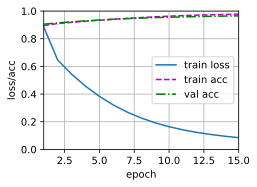

Saved figure: curve_epoch.png


([0.8851949758561394,
  0.646710817693475,
  0.5438274852648538,
  0.4569008343282041,
  0.38313172249798927,
  0.32118113619861616,
  0.26944553959907225,
  0.2270203131078899,
  0.1923824213287553,
  0.16429359742411168,
  0.14138966684728818,
  0.12291538754274511,
  0.10807349024271537,
  0.09546499705595676,
  0.08508340695291468],
 [0.89473573083415,
  0.9096693059986818,
  0.9182756423081005,
  0.9262954218176596,
  0.9335891775110241,
  0.9406214207134747,
  0.9471750449291146,
  0.9530984638082146,
  0.9583182985743592,
  0.9629483573427112,
  0.9669541757589283,
  0.9702987330467805,
  0.9730277607533756,
  0.9755455522661876,
  0.9776144550319236],
 [0.9052707898178782,
  0.9142932190552266,
  0.9227705244523124,
  0.9293929695216403,
  0.9353911308531098,
  0.9404951451594622,
  0.945269926255359,
  0.9490929894915235,
  0.9526875684778091,
  0.9555966947144576,
  0.957514523142576,
  0.9600656307514613,
  0.9620824090515745,
  0.9637285751038523,
  0.9654125220163465],
 Wi

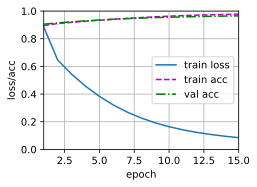

In [32]:
train_and_plot(model, train_loader, val_loader, optimizer, pad_id, 15, device)